# Requirements

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy
import nltk

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
#import proplot as plot
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
#from gensim import corpora
import seaborn as sns
#import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')

import sddk
import tempun

In [2]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

figpath = "SDAM_data/social_diversity/socdiv_figures/"

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".svg")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

# Import the dataset

In [4]:
# read local version:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")
# or use the version from sciencedata
#LIREg = s.read_file("SDAM_data/social_diversity/LIRE_occupsorgs_2021-08-31.geojson", "gdf")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[]


In [6]:
def try_eval(cell_value):
    try: return eval(cell_value)
    except: return cell_value
for col in LIRE.columns:
    LIRE[col] = LIRE[col].apply(try_eval)

# Random dates and overall simulations

In [7]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIRE["random_dates"] = LIRE.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000, seed=row.name), axis=1)

CPU times: user 29 s, sys: 940 ms, total: 30 s
Wall time: 30.4 s


In [8]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,random_dates
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"[Agios Athanasios, Photike]",313,,"[Augusti/Augustae, litterae erasae, ordo eques...",tituli honorarii,...,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[],"[311, 312, 311, 311, 311, 312, 311, 313, 313, ..."
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"[Alea, Tegea]",276,to 276; b: 276 to 282 \n\n,"[Augusti/Augustae, miliaria, viri]",miliaria,...,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[],"[276, 276, 276, 276, 276, 276, 276, 276, 276, ..."
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"[Alea, Tegea]",50,,"[Augusti/Augustae, leges, viri]",leges,...,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[],"[49, 49, 50, 49, 49, 49, 49, 50, 49, 49, 50, 5..."
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"[litterae erasae, tituli sacri]",tituli sacri,...,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[],"[204, 206, 201, 204, 208, 208, 199, 200, 199, ..."
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"[Archea Olimpia, Archaia Olympia, Olympia]",96,,{},{},...,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[],"[96, 89, 96, 92, 91, 84, 96, 81, 85, 88, 93, 8..."


In [9]:
%%time
LIRE_complete_simulations = tempun.timeblocks_from_randoms(LIRE, "random_dates", [-50, 350, 50])

CPU times: user 5.9 s, sys: 81.4 ms, total: 5.98 s
Wall time: 6.01 s


In [10]:
LIRE_complete_simulations[0]

[((-50, -1), 5222),
 ((1, 50), 20411),
 ((51, 100), 19992),
 ((101, 150), 22243),
 ((151, 200), 21966),
 ((201, 250), 18033),
 ((251, 300), 9431),
 ((301, 350), 8038)]

In [11]:
LIRE_complete_merged = tempun.simulations_merged(LIRE_complete_simulations)

In [151]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Barracks emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 68), (69, 96), (97, 192), (193, 235), (236, 284), (285, 337)]

# Occupations and organizations over time

In [13]:
var_data_occups = []
for var_n in range(1000):
    var_data_occups.append([var[var_n] for var in LIRE[LIRE["occups_N"] > 0]["random_dates"] if var !=None])

In [14]:
print(len(var_data_occups[0]))

4050


In [15]:
%%time
var_data_lire = []
for var_n in range(1000):
    var_data_lire.append([var[var_n] for var in LIRE["random_dates"] if var !=None])

CPU times: user 40.5 s, sys: 1.2 s, total: 41.7 s
Wall time: 42.6 s


In [16]:
sample_size = len(var_data_occups[0]) # + len(var_data_orgs[0])
sample_size

4050

In [17]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

CPU times: user 19.2 s, sys: 986 ms, total: 20.2 s
Wall time: 20 s


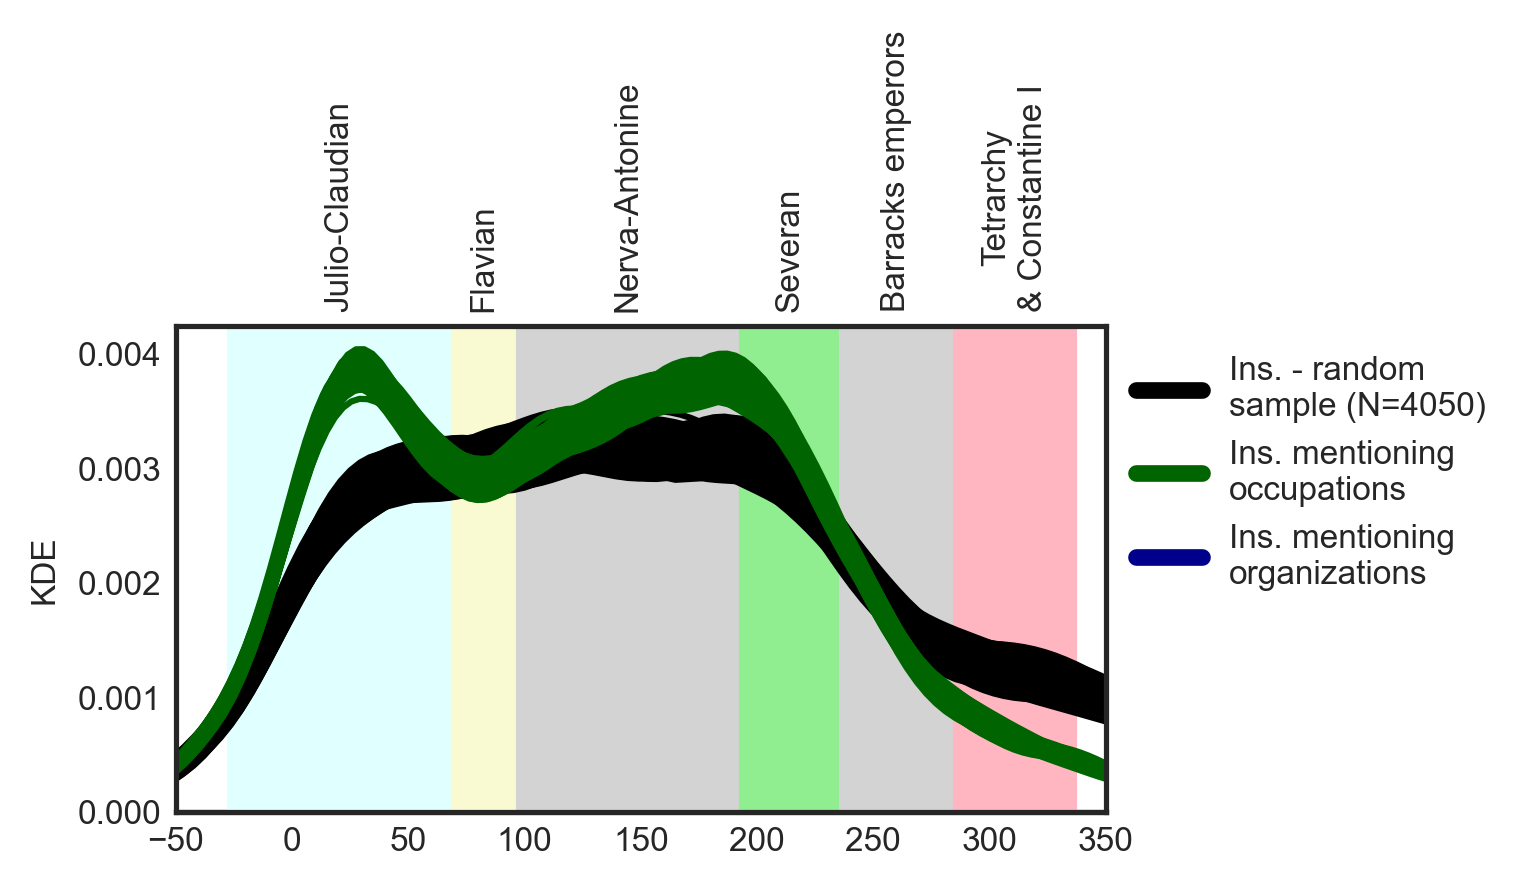

In [20]:
%%time 
# timeconsuming, because of the KDE involved

n_sim = 1000

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[5.2, 3], tight_layout=True)

for period, color in zip(periods.keys(), colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")


for data in var_data_lire[:n_sim]:
    # to be based on sample or not... 
    data = random.sample(data, k=sample_size)
    sns.kdeplot(data, ax=ax, color="black") #, alpha=0.5)   
    
for data in var_data_occups[:n_sim]:
    sns.kdeplot(data, ax=ax, color="darkgreen") #, alpha=0.5)

ax.set_xlim(-50,350)

ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")


markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkgreen", "darkblue"]]
plt.legend(markers, ["Ins. - random\nsample (N={0})".format(str(sample_size)), "Ins. mentioning\noccupations", "Ins. mentioning\norganizations"], bbox_to_anchor=(1, 1), loc='upper left')


In [21]:
save_figure(fig, "occups_vs_sample_tempdist_kde")

A file with the same name ("occups_vs_sample_tempdist_kde.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_vs_sample_tempdist_kde.eps"
A file with the same name ("occups_vs_sample_tempdist_kde.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_vs_sample_tempdist_kde.png"


# Compare temporal distributions of occupations by urban contexts

In [47]:
def get_vars(df_whole, context, n_sim=1000):
    df_context = df_whole[df_whole["urban_context_alt"]==context]
    df_context_occup = df_context[df_context["occups_N"]>0]
    type_dict = dict(df_context_occup.groupby("type_of_inscription_auto", dropna=False).size()) # groups, including Nones
    var_data_context, var_data_context_control, tb_data, tb_data_control = [], [], [], []
    timeblocks = tempun.get_timeblocks(-50, 350, 25)
    for var_n in range(n_sim):
        var_data = [var[var_n] for var in df_context_occup["random_dates"] if var !=None]
        var_data_context.append(var_data)
        tb_var_data = tempun.dates_per_block(var_data, timeblocks)
        tb_data.append(tb_var_data)
        df_sample = pd.DataFrame()
        for key in type_dict.keys():
            if isinstance(key, float): # if nan
                df_type = df_context[df_context["type_of_inscription_auto"].isnull()].sample(type_dict[key], random_state=var_n)
            else:
                df_type = df_context[df_context["type_of_inscription_auto"]==key].sample(type_dict[key], random_state=var_n)
            df_sample = pd.concat([df_sample, df_type])
        var_data_control = [var[var_n] for var in df_sample["random_dates"] if var !=None]
        var_data_context_control.append(var_data_control)
        tb_var_data_control = tempun.dates_per_block(var_data_control, timeblocks)
        tb_data_control.append(tb_var_data_control)
    return var_data_context, var_data_context_control, tb_data, tb_data_control

In [55]:
%%time
var_data_large, var_data_large_control, tb_data_large, tb_data_large_control = get_vars(LIRE, "large", 1000)
var_data_medium, var_data_medium_control, tb_data_medium, tb_data_medium_control = get_vars(LIRE, "medium", 1000)
var_data_small, var_data_small_control, tb_data_small, tb_data_small_control = get_vars(LIRE, "small", 1000)
var_data_rural, var_data_rural_control, tb_data_rural, tb_data_rural_control = get_vars(LIRE, "rural", 1000)

CPU times: user 7min 34s, sys: 6.92 s, total: 7min 41s
Wall time: 7min 41s


CPU times: user 44.3 s, sys: 3.48 s, total: 47.8 s
Wall time: 48 s


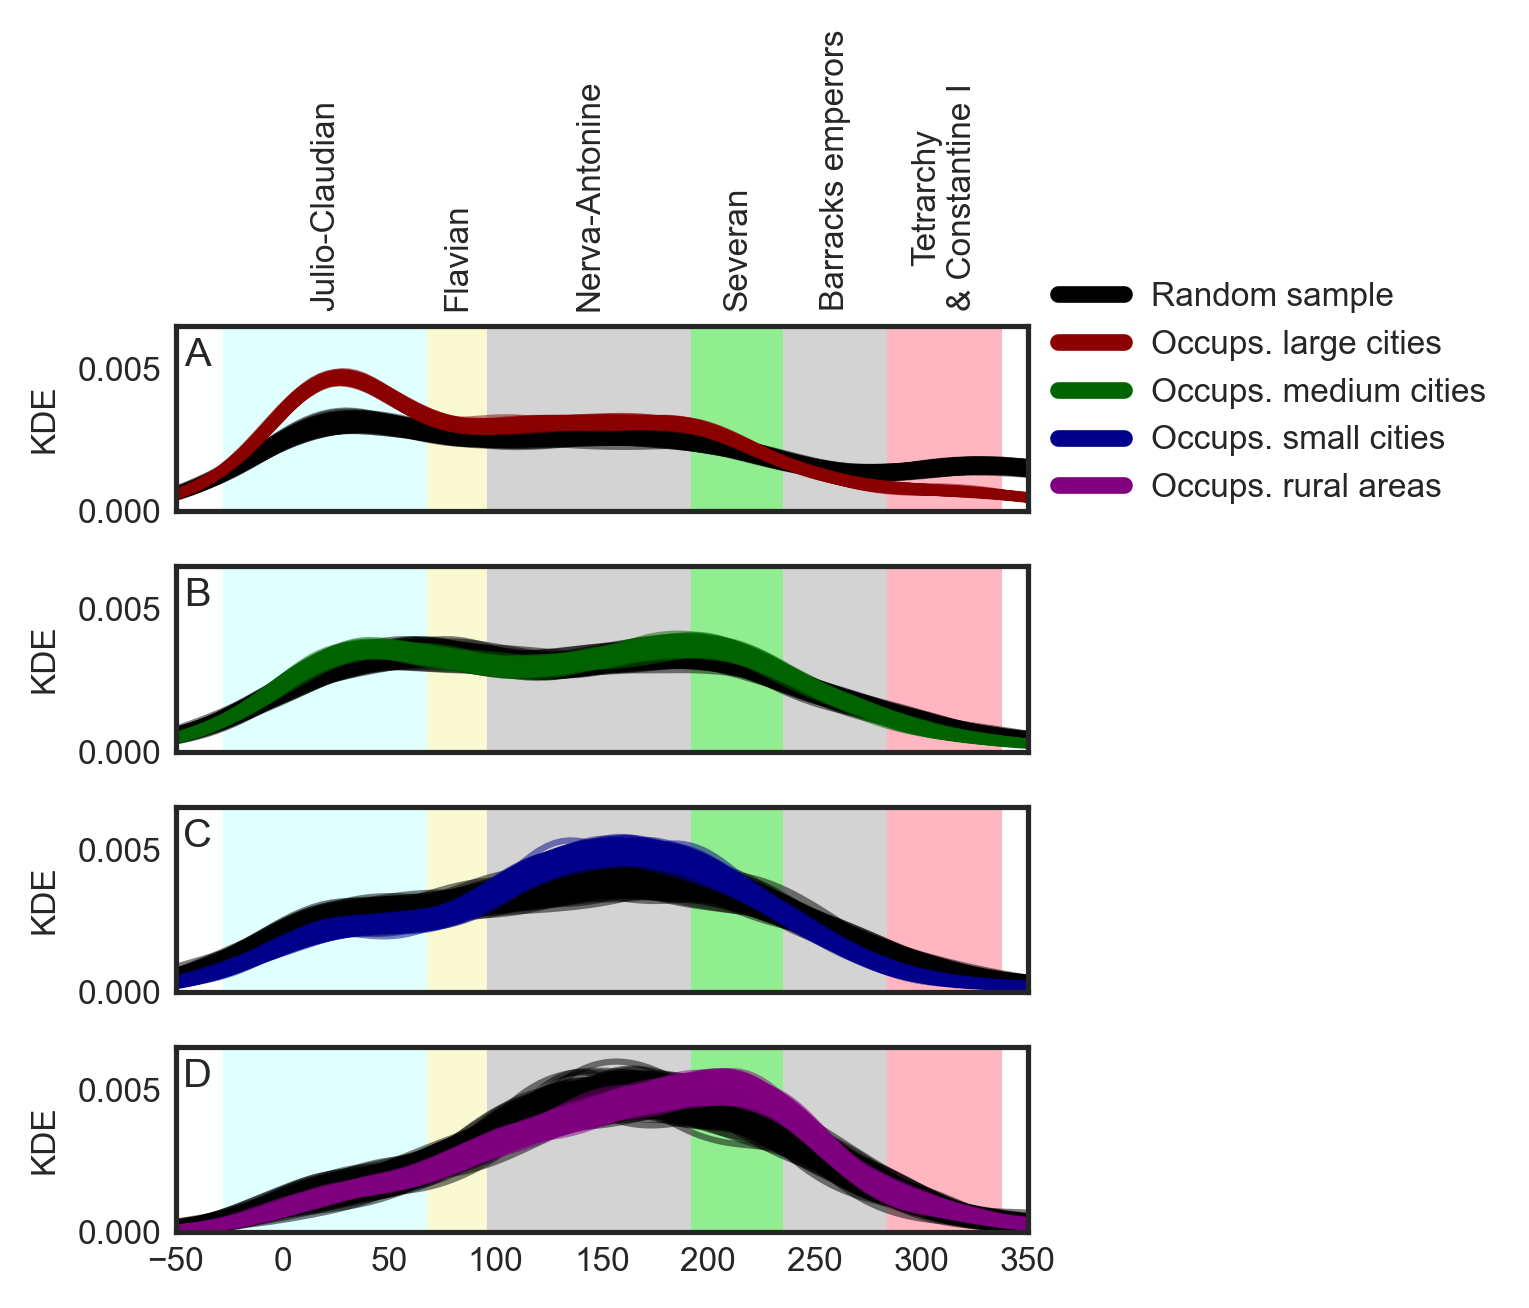

In [69]:
%%time
# timeconsuming, because of the KDE involved
n_sims = 1000
ylim_val = 0.0065

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]
#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, figsize=[5.2, 4.4], tight_layout=True)

### ax1 - large
for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()

for data in var_data_large_control[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="black", alpha=0.5)
for data in var_data_large[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="darkred", alpha=0.5)

ax1.set_xlim(-50,350)
ax1.set_ylabel("KDE")
ax1.set_ylim(0, ylim_val)

### ax2 - medium
for period, color in zip(periods.keys(), colors_list):
    ax2.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")

for data in var_data_medium_control[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="black", alpha=0.5)
for data in var_data_medium[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="darkgreen", alpha=0.5)

ax2.set_xlim(-50,350)
ax2.set_ylabel("KDE")
ax2.set_ylim(0, ylim_val)
ax2.set_xticks([])

### ax3 - small
for period, color in zip(periods.keys(), colors_list):
    ax3.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)

for data in var_data_small_control[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="black", alpha=0.5)
for data in var_data_small[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="darkblue", alpha=0.5)
ax3.set_xlim(-50,350)
ax3.set_ylabel("KDE")
ax3.set_ylim(0, ylim_val)
ax3.set_xticks([])

### ax4 - rural
for period, color in zip(periods.keys(), colors_list):
    ax4.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)

for data in var_data_rural_control[:n_sims]:
    sns.kdeplot(data, ax=ax4, color="black", alpha=0.5)
for data in var_data_rural[:n_sims]:
    sns.kdeplot(data, ax=ax4, color="purple", alpha=0.5)
ax4.set_xlim(-50,350)
ax4.set_ylabel("KDE")
ax4.set_ylim(0, ylim_val)

ax1.set_title("A", x=0.025, y=0.65)
ax2.set_title("B", x=0.025, y=0.65)
ax3.set_title("C", x=0.025, y=0.65)
ax4.set_title("D", x=0.025, y=0.65)

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkred", "darkgreen", "darkblue", "purple"]]
ax1.legend(markers, ["Random sample", "Occups. large cities", "Occups. medium cities", "Occups. small cities", "Occups. rural areas"], bbox_to_anchor=(1, 1.4), loc='upper left')

In [70]:
save_figure(fig, "occups_vs_sample_by_context_tempdist_kde")

A file with the same name ("occups_vs_sample_by_context_tempdist_kde.eps") already exists in this location.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_vs_sample_by_context_tempdist_kde.eps"
A file with the same name ("occups_vs_sample_by_context_tempdist_kde.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_vs_sample_by_context_tempdist_kde.png"


In [71]:
LIRE_large = LIRE[LIRE["urban_context_alt"]=="large"]

In [73]:
len(LIRE_large[LIRE_large["occups_N"]>0])

1872

In [75]:
len(LIRE_large[(LIRE_large["occups_N"]>0) & (LIRE_large["type_of_inscription_auto"]=="epitaph")])

883

# Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning an occupation/organization against a distribution based on a random sample of inscriptions of the same length. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [62]:
def ks_per_samplesets(sampleset, sampleset_control, subsample_len=None):
    if subsample_len == None:
        subsample_len = len(sampleset[0])
    KS_statistic = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).statistic for n in range(0,1000)]), 4)
    p_values = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).pvalue for n in range(0,1000)]), 10)
    return KS_statistic, p_values

In [63]:
for sample_data, sample_control in (
        (var_data_large, var_data_large_control),
        (var_data_medium, var_data_medium_control),
        (var_data_small, var_data_small_control),
        (var_data_rural, var_data_rural_control)):
    print(ks_per_samplesets(sample_data, sample_control))

(0.1678, 0.0)
(0.0473, 0.2463314784)
(0.0725, 0.0822951727)
(0.0803, 0.2439328371)


# A closer look at Rome in the first half of the 1st century

In [82]:
LIRE_rome = LIRE_large[LIRE_large["large_city_ID"]==992]
len(LIRE_rome)

39882

In [97]:
n_sim = 1000
period_start = 1
period_end = 50
lire_1_50_Ns, lire_1_50_occups_Ns, lire_large_1_50_Ns, lire_large_1_50_occups_Ns, rome_1_50_Ns, rome_1_50_occups_Ns = [], [], [], [], [], []
for n in range(n_sim):
    # LIRE as a whole in the first half of the 1st century
    dates_var = LIRE["random_dates"].apply(lambda x: x[n])
    df_sub = LIRE[dates_var.between(period_start,period_end)]
    lire_1_50_Ns.append(len(df_sub))
    lire_1_50_occups_Ns.append(df_sub["occups_N"].sum())
    # LIRE large in the first half of the 1st century
    dates_var = LIRE_large["random_dates"].apply(lambda x: x[n])
    df_sub = LIRE_large[dates_var.between(period_start,period_end)]
    lire_large_1_50_Ns.append(len(df_sub))
    rome_1_50_occups_Ns.append(df_sub["occups_N"].sum())
    # Rome alone in the first half of the 1st century
    dates_var = LIRE_rome["random_dates"].apply(lambda x: x[n])
    df_sub = LIRE_rome[dates_var.between(period_start,period_end)]
    rome_1_50_Ns.append(len(df_sub))
    rome_1_50_occups_Ns.append(df_sub["occups_N"].sum())

In [99]:
print(pd.Series(lire_1_50_Ns).describe())
print(pd.Series(lire_1_50_occups_Ns).describe())
print(pd.Series(lire_large_1_50_Ns).describe())
print(pd.Series(lire_large_1_50_occups_Ns).describe())
print(pd.Series(rome_1_50_Ns).describe())
print(pd.Series(rome_1_50_occups_Ns).describe())

count     1000.000000
mean     20292.573000
std         79.546819
min      20064.000000
25%      20239.750000
50%      20292.000000
75%      20349.000000
max      20529.000000
dtype: float64
count    1000.000000
mean     1003.861000
std        19.475702
min       946.000000
25%       991.000000
50%      1004.000000
75%      1017.250000
max      1073.000000
dtype: float64
count    1000.000000
mean     7051.422000
std        37.921181
min      6928.000000
25%      7025.000000
50%      7051.000000
75%      7078.000000
max      7177.000000
dtype: float64
count    1000.000000
mean      546.259000
std        12.044376
min       514.000000
25%       538.000000
50%       546.000000
75%       555.000000
max       585.000000
dtype: float64


In [100]:
7051.422000 / 20292.573000

0.34748782226876795

In [111]:
8142.367899 / 20292.573000

0.40124866861388153

In [101]:
7051.422000 / len(LIRE)

0.05177635656068727

In [103]:
546.259000 / LIRE["occups_N"].sum()

0.10541470474720185

# Occupations & organizations over inscription types

In [112]:
simulations_by_type_len = []

for ins_type in LIRE["type_of_inscription_auto"].unique():
    if ins_type != "NULL":
        subset_df = LIRE[LIRE["type_of_inscription_auto"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 74578),
 ('votive inscription', 15700),
 ('owner/artist inscription', 10460),
 ('honorific inscription', 5573),
 ('building/dedicatory inscription', 3241),
 ('mile-/leaguestone', 2536),
 ('identification inscription', 1910),
 ('acclamation', 443),
 ('boundary inscription', 410),
 ('military diploma', 329),
 ('list', 294),
 ('defixio', 292),
 ('letter', 288),
 ('label', 273),
 ('elogium', 150),
 ('public legal inscription', 132),
 ('seat inscription', 54),
 ('private legal inscription', 37),
 ('prayer', 23),
 ('assignation inscription', 16),
 ('calendar', 13),
 ('adnuntiatio', 1),
 (None, 0)]

In [115]:
# N of occuptions and N of organization per inscription category
ins_types_occs_orgs = []
for ins_type_tup in simulations_by_type_len[:-1]:
    subset_df = LIRE[LIRE["type_of_inscription_clean"]==ins_type_tup[0]]
    occ_N = subset_df["occups_N"].sum()
    ins_types_occs_orgs.append([ins_type_tup[0] + " (N={0})".format(len(subset_df)), occ_N])
    print("inscription type: {0}, N of occupations: {1}".format(ins_type_tup[0], str(occ_N)))

inscription type: epitaph, N of occupations: 588
inscription type: votive inscription, N of occupations: 377
inscription type: owner/artist inscription, N of occupations: 34
inscription type: honorific inscription, N of occupations: 353
inscription type: building/dedicatory inscription, N of occupations: 110
inscription type: mile-/leaguestone, N of occupations: 0
inscription type: identification inscription, N of occupations: 11
inscription type: acclamation, N of occupations: 3
inscription type: boundary inscription, N of occupations: 9
inscription type: military diploma, N of occupations: 38
inscription type: list, N of occupations: 0
inscription type: defixio, N of occupations: 6
inscription type: letter, N of occupations: 10
inscription type: label, N of occupations: 0
inscription type: elogium, N of occupations: 2
inscription type: public legal inscription, N of occupations: 44
inscription type: seat inscription, N of occupations: 0
inscription type: private legal inscription, N 

In [116]:
pd.DataFrame(ins_types_occs_orgs, columns=["inscription type", "occupations"])

,inscription type,occupations
0,epitaph (N=22356),588
1,votive inscription (N=12177),377
2,owner/artist inscription (N=3734),34
3,honorific inscription (N=3062),353
4,building/dedicatory inscription (N=2661),110
5,mile-/leaguestone (N=1395),0
6,identification inscription (N=1165),11
7,acclamation (N=359),3
8,boundary inscription (N=177),9
9,military diploma (N=212),38


In [117]:
def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

In [118]:
types, occups_freqs = [], []

for ins_type_tup in simulations_by_type_len[:10][::-1]: # for horizontal bar below, we need the list in reverse order, therefore: [::-1]
    subset_df = LIRE[LIRE["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    occups_freqs.append(subset_df["occups_N"].sum() / subset_wordcount * 1000)

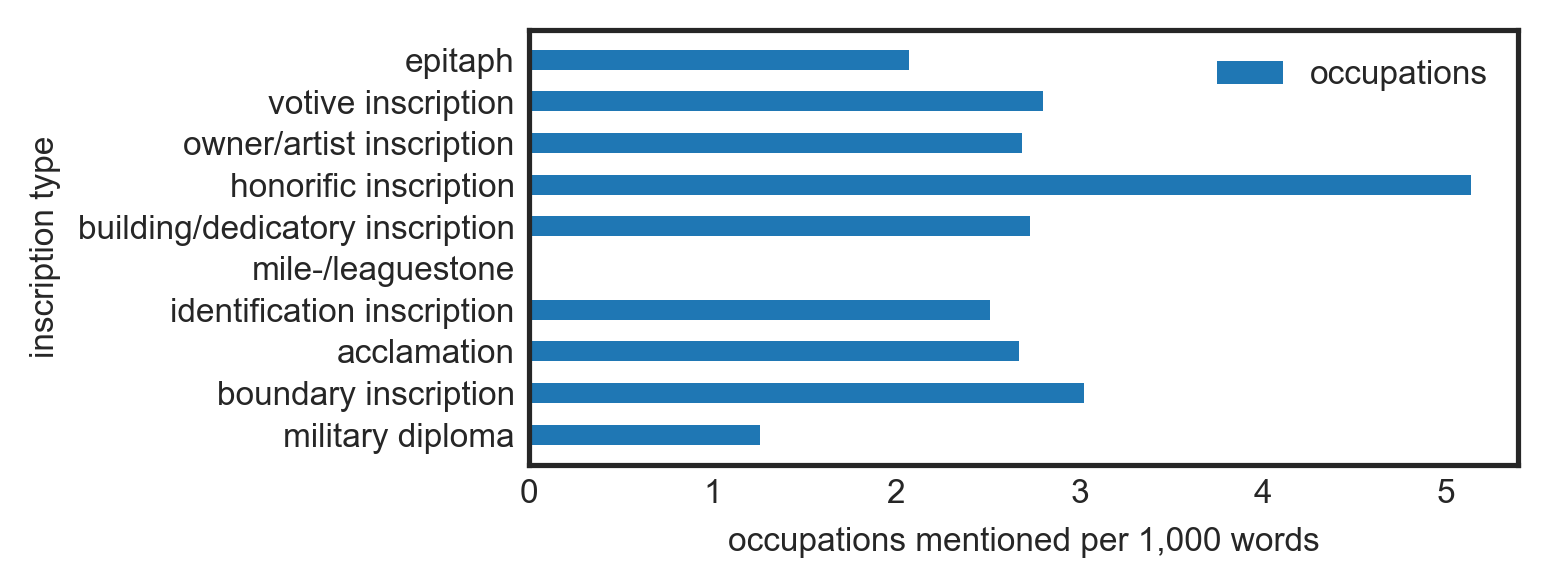

In [119]:
fig, ax  = plt.subplots(figsize=(5.2, 2), tight_layout=True)

y = np.arange(len(types))
height = 0.48

ax.barh(y, occups_freqs, height, label="occupations", color="tab:blue") #, color=tab_colors_list[:len(simulations_by_type)])

ax.set_yticks(y) #y_pos, types)
ax.set_yticklabels(types) #, rotation="vertical")
ax.set_xlabel("occupations mentioned per 1,000 words")
ax.set_ylabel("inscription type")
ax.legend()

In [121]:
save_figure(fig, "occups_by_inscrtypes")

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_by_inscrtypes.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_by_inscrtypes.png"


In [74]:
s.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png", fig)
s.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.eps", fig)

A file with the same name ("EDH_occupsorgs_by_instypes.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.eps"


# Occupations & organizations together
(not used now...)

In [123]:
len(LIRE[LIRE["organizations_N"]>0])

1229

In [124]:
len(LIRE[LIRE["occups_N"]>0])

4050

In [125]:
len(LIRE[(LIRE["occups_N"]>0) & (LIRE["organizations_N"]>0)])

554

In [129]:
# does not work... see previous versions....
#LIRE["occupsorgs"] = LIRE.apply(lambda row: eval(row["occups"]) + eval(row["organizations"]), axis=1)

# Occupations & Organizations over centuries

In [130]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

def orgs_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["organizations_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

def orgs_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["organizations_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

# various metrics on the level of timeblocks
def unique_occups(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_occups

# unique occups / inscriptions
def unique_occups_ins_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    return unique_occups / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [132]:
%%time
occups_counts = tempun.sim_data_by_function(LIRE, 100, [-50, 350, 50], occups_count)
occups_ins_ratio = tempun.sim_data_by_function(LIRE, 100, [-50, 350, 50], occups_inscriptions_ratio)
occups_TF_data = tempun.sim_data_by_function(LIRE, 100, [-50, 350, 50], occups_cumulTF)
unique_occups_data = tempun.sim_data_by_function(LIRE, 100, [-50, 350, 50], unique_occups)
unique_occups_ratio_data = tempun.sim_data_by_function(LIRE, 100, [-50, 350, 50], unique_occups_ratio)
unique_occups_ins_ratio_data = tempun.sim_data_by_function(LIRE, 100, [-50, 350, 50], unique_occups_ins_ratio)

CPU times: user 3min 9s, sys: 7.94 s, total: 3min 17s
Wall time: 3min 18s


In [136]:
sim_data_list = [
    (occups_counts, "(A) occups count", "occups mentions count"),
    (occups_ins_ratio, "(B) occups per 100 inscrs", "occups"),
    (occups_TF_data, "(C) occups per 1000 words", "occups"),
    (unique_occups_data, "(D) unique occups", "unique occups"),
    (unique_occups_ratio_data, "(E) unique occups\nper 1000 unique words", "unique occups"),
    (unique_occups_ins_ratio_data, "(F) unique occups\nper 100 inscrs", "unique occups")
]

In [134]:
unique_occups_data[0]

[((-50, -1), 75),
 ((1, 50), 171),
 ((51, 100), 133),
 ((101, 150), 149),
 ((151, 200), 145),
 ((201, 250), 124),
 ((251, 300), 75),
 ((301, 350), 58)]

In [135]:
colors_base_list = list(mcolors.BASE_COLORS)

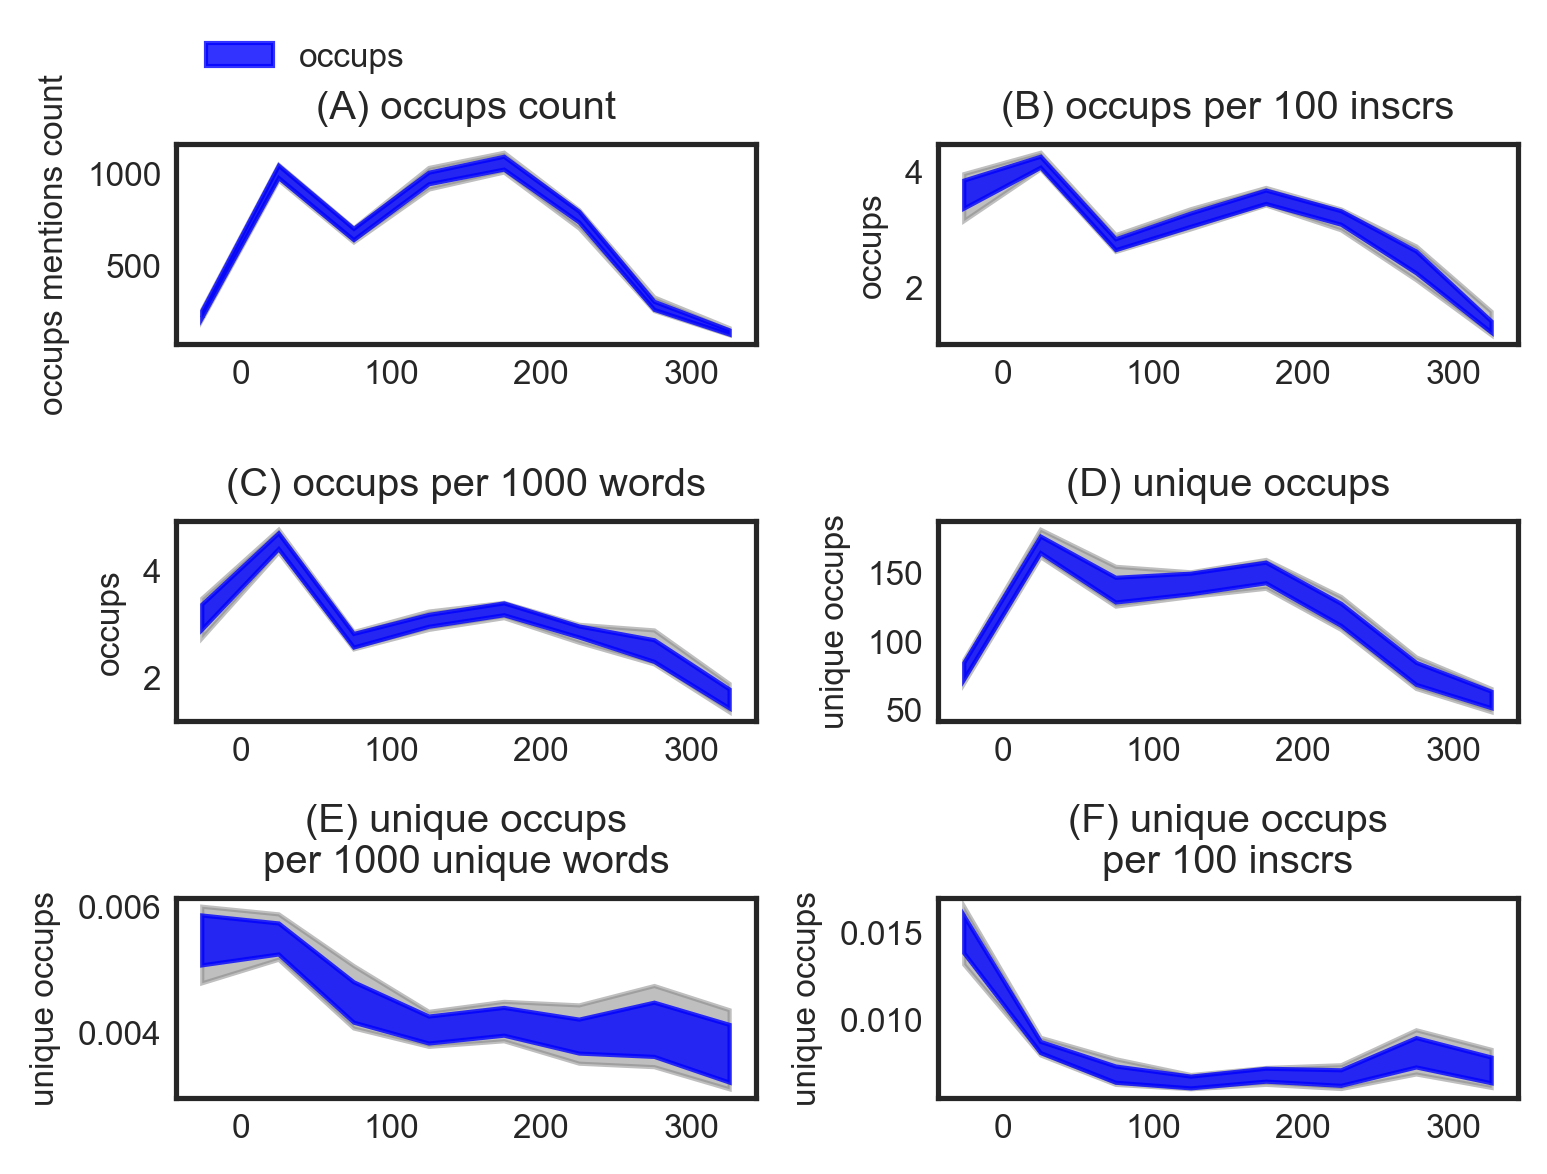

In [137]:
#plt.style.use("seaborn-white")

fig, axs  = plt.subplots(3, 2, figsize=(5.2, 4), tight_layout=True)
n = 0
for sim_data, ax in zip(sim_data_list, axs.ravel()):
        tempun.plot_timeblocks_data(sim_data[0], ax, "blue", label="occups", alpha=0.8)
        n += 1
        ax.set_title(sim_data[1])
        ax.set_ylabel(sim_data[2])
        if sim_data[1] == "(A) occups count":
            ax.legend(ncol=2, bbox_to_anchor=(0, 1.2), loc="lower left")

In [138]:
save_figure(fig, "occups_temporal_various_metrics")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_temporal_various_metrics.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_temporal_various_metrics.png"


# Occupations & organizations by periods

In [140]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["occups_N"].sum()
    return occups_N_sum

def orgs_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["organizations_N"].sum()
    return occups_N_sum

In [ ]:
%%time

# time consuming, apply carefully
#occups_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_count) 
occups_ins_ratio = tempun.sim_data_by_function(LIRE, 1000, timeblocks_periods, occups_per_1K_ins)

In [ ]:
occups_ins_ratio[2]

In [ ]:
def simulations_merged(simulation_data):
    merged_data = []
    for n in range(len(simulation_data[0])): # choose the first simulation to get the length 
        merged_data.append((simulation_data[0][n][0], [sim[n][1] for sim in simulation_data]))
    return merged_data

occups_ratios_merged = simulations_merged(occups_ins_ratio)

In [ ]:
[key for key in periods.keys()]

In [ ]:
[abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]

In [ ]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation. 


labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]


fig, ax1 = plt.subplots(1,1, figsize=[5.2,3], tight_layout=True)

data1 = [tup[1] for tup in occups_ratios_merged]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged]

bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)

ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.set_ylim(0, 88)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.secondary_xaxis("bottom")
ax1.set_xlim(-50, 350)


# fill with colors
colors =tab_colors_list[:len(labels)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

In [ ]:
save_figure(fig, "occups_by_periods_bar")